In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import time
import glob
import joblib
import pickle
import random
import warnings
import tensorflow as tf
from PIL import Image
from joblib import dump, load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.utils import shuffle
from skimage.color import rgb2gray

print("Number of GPUs Available for TensorFlow: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPUs Available for TensorFlow:  1


In [17]:
# Function to filter out images smaller than a specified width and height
def filter_small_images(image_paths, min_width=32, min_height=32):
    """Filter out images smaller than the specified min_width and min_height."""
    filtered_paths = []
    for path in image_paths:
        with Image.open(path) as img:
            width, height = img.size
            if width >= min_width and height >= min_height:
                filtered_paths.append(path)
    return filtered_paths

# Function to retrieve images from a directory
def get_images_from_directory(directory, extensions):
    """Retrieve images with specified extensions from a directory."""
    images = []
    for ext in extensions:
        images.extend(glob.glob(f'{directory}/*.{ext}'))
    return images

# Specify common image extensions
extensions = ['png', 'jpg']

# Specify the categories of images
categories = [
    'ambulance', 'bus', 'car', 'crosswalk', 'cyclist', 'dont-care', 'fire-hydrant',
    'green-forward-traffic-light', 'green-advance-left-traffic-light', 'green-traffic-light',
    'misc', 'motorcycle', 'no-object', 'pedestrian', 'person', 'red-advance-left-traffic-light',
    'red-traffic-light', 'scooter', 'stop-sign', 'traffic-cone', 'tram', 'truck', 'van',
    'yellow-traffic-light', 'yellow-advance-left-traffic-light'
]

image_data = {}

# Load images from directories into arrays
for category in categories:
    images = filter_small_images(get_images_from_directory(f'..\\datasets\\classification-full\\cropped-images\\{category}', extensions))
    image_data[category] = images
    print(f'Images with {category.replace("-", " ")}: {len(images)}')

Images with ambulance: 248
Images with bus: 359
Images with car: 29236
Images with crosswalk: 131
Images with cyclist: 1671
Images with dont care: 7079
Images with fire hydrant: 103
Images with green forward traffic light: 78
Images with green advance left traffic light: 249
Images with green traffic light: 2674
Images with misc: 639
Images with motorcycle: 273
Images with no object: 17961
Images with pedestrian: 7311
Images with person: 666
Images with red advance left traffic light: 110
Images with red traffic light: 2729
Images with scooter: 90
Images with stop sign: 54
Images with traffic cone: 87
Images with tram: 687
Images with truck: 1396
Images with van: 2560
Images with yellow traffic light: 102
Images with yellow advance left traffic light: 33


In [3]:
X = {}
y = {}

for i, category in enumerate(categories):
    X[category] = []
    for path in image_data[category]:
        img = image.load_img(path, target_size=(64, 64))  # Load and resize the image
        img_array = image.img_to_array(img)  # Normalize to [0, 1]
        img_array = img_array / 255.0
        X[category].append(img_array)
    
    X[category] = np.array(X[category])  # Convert list to a numpy array
    y[category] = np.full(len(X[category]), i)
    
    print(f'{category.capitalize()} features shape: {X[category].shape}')
    print(f'{category.capitalize()} labels shape: {y[category].shape}')

# Convert X into a vstack of all categories
X = np.vstack(X.values())
print(f'All features shape: {X.shape}')

# Convert y into an hstack of all categories
y = np.hstack(y.values())
print(f'All labels shape: {y.shape}')

Ambulance features shape: (248, 64, 64, 3)
Ambulance labels shape: (248,)
Bus features shape: (359, 64, 64, 3)
Bus labels shape: (359,)
Car features shape: (29236, 64, 64, 3)
Car labels shape: (29236,)
Crosswalk features shape: (131, 64, 64, 3)
Crosswalk labels shape: (131,)
Cyclist features shape: (1671, 64, 64, 3)
Cyclist labels shape: (1671,)
Dont-care features shape: (7079, 64, 64, 3)
Dont-care labels shape: (7079,)
Fire-hydrant features shape: (103, 64, 64, 3)
Fire-hydrant labels shape: (103,)
Green-forward-traffic-light features shape: (78, 64, 64, 3)
Green-forward-traffic-light labels shape: (78,)
Green-advance-left-traffic-light features shape: (249, 64, 64, 3)
Green-advance-left-traffic-light labels shape: (249,)
Green-traffic-light features shape: (2674, 64, 64, 3)
Green-traffic-light labels shape: (2674,)
Misc features shape: (639, 64, 64, 3)
Misc labels shape: (639,)
Motorcycle features shape: (273, 64, 64, 3)
Motorcycle labels shape: (273,)
No-object features shape: (17961

C:\Users\Ali\AppData\Local\Temp\ipykernel_12400\3764025994.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.vstack(X.values())


All features shape: (76526, 64, 64, 3)
All labels shape: (76526,)


C:\Users\Ali\AppData\Local\Temp\ipykernel_12400\3764025994.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y = np.hstack(y.values())


In [11]:
# with open("output.txt", "w") as file:
#     for i in y:
#         file.write(str(i) + "\n")

#y = tf.keras.utils.to_categorical(y, 10)

X, y = shuffle(X, y)

# with open("output2.txt", "w") as file:
#     for i in y:
#         file.write(str(i) + "\n")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

# Data Preparation
# Shuffle the dataset
#X_train, y_train = shuffle(X_train, y_train)
#X_test, y_test = shuffle(X_test, y_test)

print(f'Train features shape: {X_train.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test features shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

# # Convert the images to grayscale
X_train_gray = np.sum(X_train/3, axis = 3, keepdims = True)
X_test_gray = np.sum(X_test/3, axis = 3, keepdims = True)

# # Normalize the images
X_train_gray_normalized = (X_train_gray - 128)/128
X_test_gray_normalized = (X_test_gray - 128)/128

#print(X_train_gray_normalized.shape)
#print(X_test_gray_normalized.shape)

Train features shape: (57394, 64, 64, 3)
Train labels shape: (57394,)
Test features shape: (19132, 64, 64, 3)
Test labels shape: (19132,)


class: dont-care
class: no-object
class: pedestrian
class: cyclist
class: green-traffic-light
class: red-traffic-light
class: no-object
class: dont-care
class: pedestrian
class: no-object
class: van
class: no-object
class: car
class: car
class: car
class: cyclist
class: car
class: car
class: van
class: no-object
class: dont-care
class: van
class: car
class: car
class: car


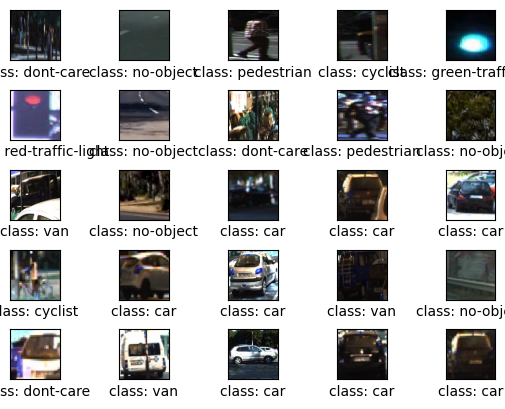

In [12]:
fig, axes = plt.subplots(5, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.8)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])

    xlabel = "class: {0}".format(categories[int(y_train[i])])
    print(xlabel)

    # Show the classes as the label on the x-axis
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
image_shape = X_train[i].shape

cnn_model = Sequential()
cnn_model.add(Input(shape = image_shape))
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) #, padding='same'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) #, padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(25, activation='sigmoid')) # 43 classes because there are 43 different traffic signs as possible outputs

# specify the path to save the model
checkpoints_filepath = "..\\saved-models\\best_cnn_model.hdf5"

# initialize the ModelCheckpoint callback
checkpoints = ModelCheckpoint(checkpoints_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

cnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])



model_training_time_label = 'CNN object classification training time: '

# Record the time it takes to train the model
start_time = time.time()

early_stopper = EarlyStopping(monitor = 'accuracy', min_delta = 0.001, patience = 15, verbose = 1, mode = 'auto', restore_best_weights=True)

history = cnn_model.fit(X_train, y_train, 
                        batch_size = 64, 
                        epochs = 200, 
                        verbose = 1, 
                        validation_split = (0.1),
                        callbacks = [checkpoints, early_stopper])

end_time = time.time()

training_time = end_time - start_time

# Output the training time into the file
with open('..\\model-comparison-metrics', 'a') as f:
    f.write(f'{model_training_time_label}{training_time}\n')

print("Training time: {0}".format(training_time))

# Output model summary
cnn_model.summary()


# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

# opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0001, decay = 1e-6)

# model = createModel(X_train.shape[1:])

# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.summary()

Epoch 1/200
808/808 [==============================] - ETA: 0s - loss: 1.1309 - accuracy: 0.6856
Epoch 1: val_loss improved from inf to 0.61624, saving model to ..\saved-models\best_cnn_model.hdf5
808/808 [==============================] - 25s 30ms/step - loss: 1.1309 - accuracy: 0.6856 - val_loss: 0.6162 - val_accuracy: 0.8120
Epoch 2/200
807/808 [============================>.] - ETA: 0s - loss: 0.7323 - accuracy: 0.7844
Epoch 2: val_loss improved from 0.61624 to 0.51263, saving model to ..\saved-models\best_cnn_model.hdf5
808/808 [==============================] - 24s 30ms/step - loss: 0.7322 - accuracy: 0.7845 - val_loss: 0.5126 - val_accuracy: 0.8448
Epoch 3/200
806/808 [============================>.] - ETA: 0s - loss: 0.6245 - accuracy: 0.8080
Epoch 3: val_loss improved from 0.51263 to 0.44121, saving model to ..\saved-models\best_cnn_model.hdf5
808/808 [==============================] - 24s 30ms/step - loss: 0.6248 - accuracy: 0.8080 - val_loss: 0.4412 - val_accuracy: 0.8575
Ep

In [18]:
# Ouput test accuracy
score = cnn_model.evaluate(X_test, y_test, verbose = 0)
print('Test Accuracy: {}'.format(score[1]))

model_path = '..\\saved-models\\object-classification-cnn.pkl'  # replace with the path to your model
dump(cnn_model, model_path) # Save the model
#model = load(model_path)

Test Accuracy: 0.9351348280906677


INFO:tensorflow:Assets written to: ram://0a690cb8-581b-40bb-8f04-2532f0c6629e/assets


INFO:tensorflow:Assets written to: ram://0a690cb8-581b-40bb-8f04-2532f0c6629e/assets


['..\\saved-models\\object-classification-cnn.pkl']

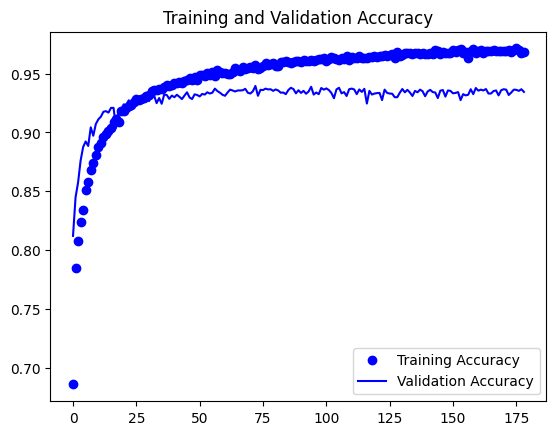

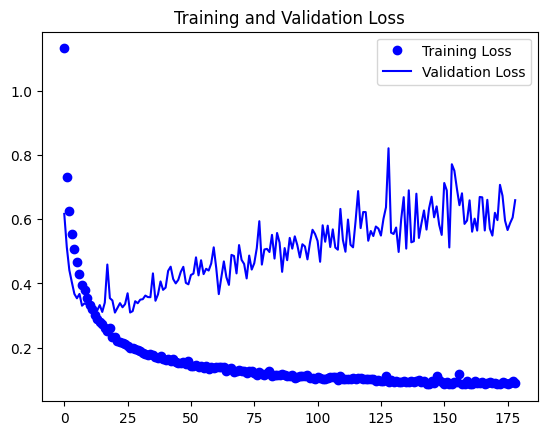

In [19]:
%matplotlib inline
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [20]:
model_prediction_time_label = 'CNN object classification prediction time: '

# Record the prediction time
start_time = time.time()

# Get the predictions for the test data
y_predicted = cnn_model.predict(X_test)

# Use this for Multi-class classification
y_predicted_classes = np.argmax(y_predicted, axis=1)

# Use this for Multi-class classification
# y_predict_classes = np.argmax(y_predict, axis=1) # Try removing argmax and see what happens

# Use this for Binary classification
#predicted_classes = cnn_model.predict(X_test_gray_normalized)

# Get the indices to be plotted
y_true = y_test
correct = np.nonzero(y_predicted_classes == y_true)
incorrect = np.nonzero(y_predicted_classes != y_true)

# Mark the end time for prediction
end_time = time.time()

# Calculate prediction time
prediction_time = end_time - start_time

# Output the prediction time into the file
with open('model-comparison-metrics', 'a') as f:
    f.write(f'{model_prediction_time_label}{prediction_time}\\n')

print("Prediction time: {0}".format(prediction_time))

598/598 [==============================] - 6s 10ms/step
Prediction time: 8.21154236793518


              precision    recall  f1-score   support

           0       0.96      0.83      0.89        53
           1       0.63      0.72      0.67        82
           2       0.92      0.97      0.94      7448
           3       0.75      0.09      0.17        32
           4       0.93      0.78      0.85       431
           5       0.85      0.80      0.82      1752
           6       0.86      0.18      0.29        34
           7       1.00      0.59      0.74        17
           8       0.17      0.04      0.07        70
           9       0.90      0.98      0.93       657
          10       0.93      0.72      0.81       141
          11       0.88      0.51      0.64        75
          12       0.98      0.99      0.99      4523
          13       0.89      0.96      0.92      1733
          14       0.95      0.65      0.77       159
          15       1.00      0.77      0.87        30
          16       0.99      1.00      0.99       696
          17       0.33    

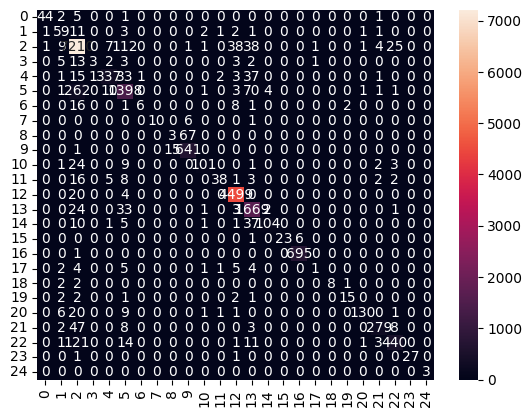

In [21]:
cm = confusion_matrix(y_test, y_predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_predicted_classes))

In [22]:
scores = cnn_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

598/598 [==============================] - 7s 11ms/step - loss: 0.6009 - accuracy: 0.9351
Test loss: 0.6008683443069458
Test accuracy: 0.9351348280906677


1/1 [==============================] - 0s 22ms/step


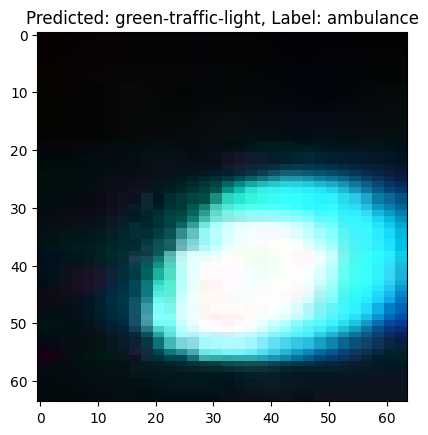

1/1 [==============================] - 0s 21ms/step


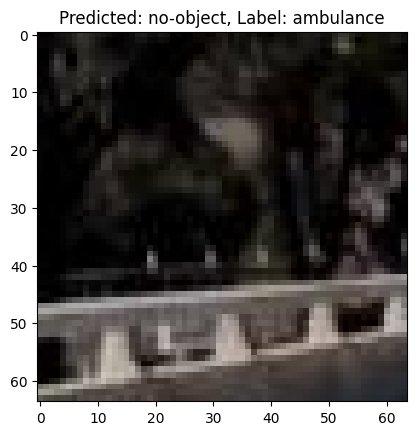

1/1 [==============================] - 0s 169ms/step


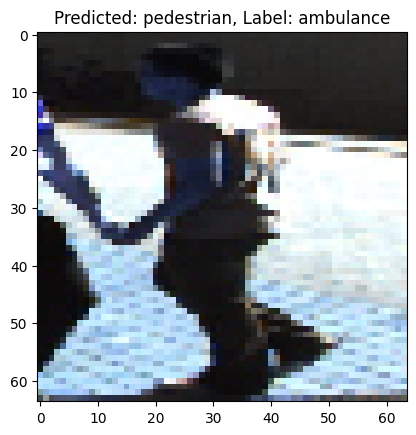

1/1 [==============================] - 0s 26ms/step


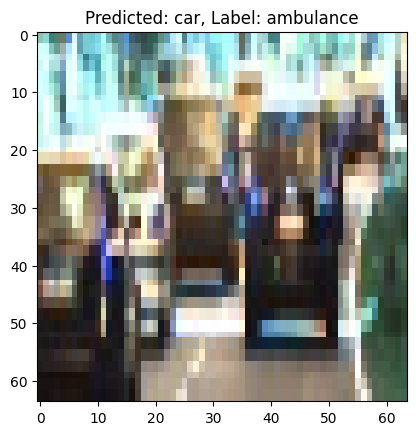

1/1 [==============================] - 0s 24ms/step


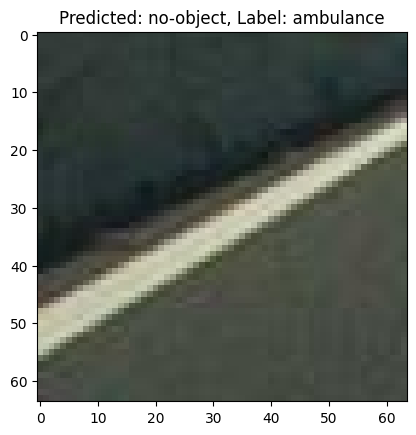

1/1 [==============================] - 0s 23ms/step


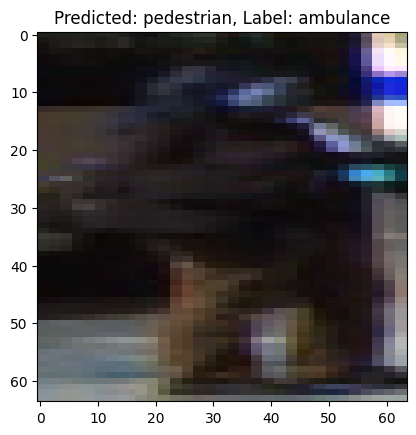

1/1 [==============================] - 0s 27ms/step


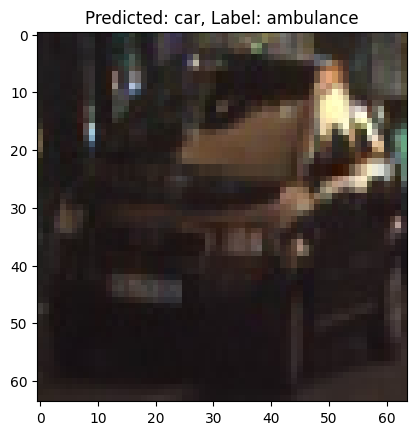

1/1 [==============================] - 0s 22ms/step


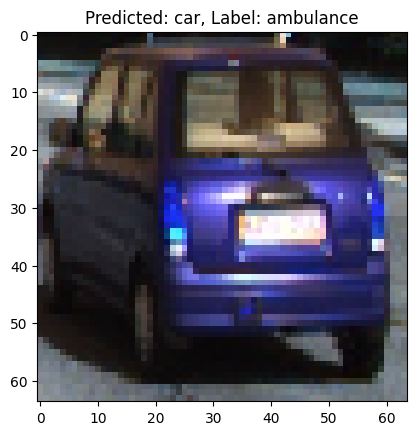

1/1 [==============================] - 0s 20ms/step


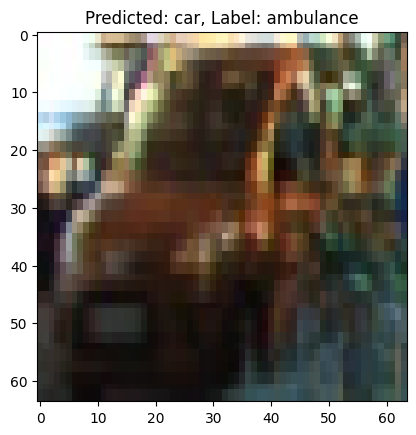

1/1 [==============================] - 0s 23ms/step


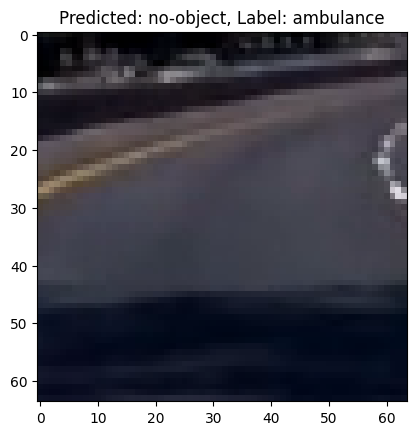

In [26]:
# Iterate over first 10 test images
for x in range(10):
    # Get test image
    test_image = X_test[x,:]
    
    # Predict class of image
    predicted_cat = cnn_model.predict(np.array([test_image])).argmax()
    
    # Get actual class of image
    label = y_test[x].argmax()
    
    # If prediction is incorrect, display image with predicted and actual classes
    if (predicted_cat != label):
        plt.title(f"Predicted: {categories[predicted_cat]}, Label: {categories[label]}")
        plt.imshow(test_image)
        plt.show()

In [29]:
model_path = '..\saved-models\object-classification-cnn1.pkl'  # replace with path to model
model_path2 = '..\saved-models\object-classification-cnn2.pkl'  # replace with path to model
dump(cnn_model, model_path) # Save the model

model = load(model_path) # Load the model

# save
with open(model_path2,'wb') as f:
    pickle.dump(cnn_model,f)

# load
# with open(model_path2, 'rb') as f:
#     model = pickle.load(f)

#model = cnn_model

INFO:tensorflow:Assets written to: ram://9f790ba9-9e62-4dce-844b-330afa40be6c/assets


INFO:tensorflow:Assets written to: ram://9f790ba9-9e62-4dce-844b-330afa40be6c/assets


FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://1f476c6a-d357-4233-8e37-88a6c848657d/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [30]:
video_path = 'testsets/videos/1.mp4'
video_path_out = '{}_out.mp4'.format(video_path)

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0]))


while ret:

    results = cnn_model(frame)[0]
    threshold = 0.3
    for result in results.boxes.data.tolist():
        print(len(result))
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper()+(str(score)), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()

: 



Ali